This tutorial deals with __reshaping a 2D ensemble to a 3D cube__. The cube can then, for instance, be displayed using mayavi. 

Let's start by importing some packages (including the seisio package itself) and setting up the logging config.

In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.insert(1, '../')

import seisio

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s', force=True)
log = logging.getLogger("main")

Let's load a small test data set. For an actual field data example, this would most likely be poststack data, migrated or unmigrated. It could also be a cross-spread gather. We need some trace headers to define the dimensions of the cube. Typically for 3D poststack data, that's an inline and crossline number but other header values can also be used.

In [2]:
dataset = np.load("data/cube.npy")

Now let's check on what we've got. We can output a trace header statistics:

In [3]:
thstat = seisio.log_thstat(dataset)
ntraces = len(dataset)
log.info("Number of traces: %d", ntraces)

INFO: Summary of trace header statistics (zeros excluded):
+-------+-------+-------+------------+------------+---------+---------+
|       |   min |   max |       mean |        std |     25% |     75% |
|-------+-------+-------+------------+------------+---------+---------|
| tracl |     1 |  3068 | 1374.32    | 1143.45    |   10.25 | 2046.75 |
| trid  |     1 |     1 |    1       |    0       |    1    |    1    |
| ns    |   601 |   601 |  601       |    0       |  601    |  601    |
| dt    |  5000 |  5000 | 5000       |    0       | 5000    | 5000    |
| iline |   101 |   107 |  103.684   |    2.24337 |  101    |  105    |
| xline |     1 |    11 |    5.36842 |    2.96302 |    3    |    7.75 |
+-------+-------+-------+------------+------------+---------+---------+
INFO: Number of traces: 38


This is a very small poststack data set, consisting of four inlines and eleven crosslines. However, as we will find out shortly, not all inlines/crosslines are fully populated (the total number of traces already indicates this fact as there are only 38 and not 44 traces). In case all lines were fully populated, we could just use np.sort and np.reshape to convert the 2D ensemble of data into a 3D cube. All traces are "live", as the trace ID header ("trid") shows. Let's check on the data geometry by creating a crossplot of inline-vs-crossline numbers:

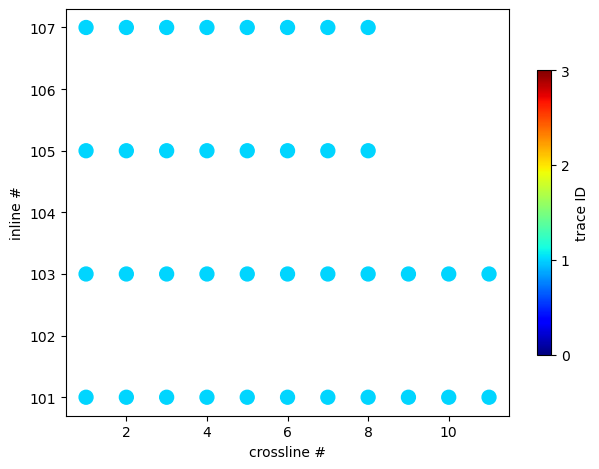

In [4]:
fig1, ax1 = plt.subplots(1, 1)
sc1 = ax1.scatter(dataset["xline"], dataset["iline"], c=dataset["trid"], s=100, cmap="jet", vmin=0, vmax=3)
ax1.set_xlabel("crossline #")
ax1.set_ylabel("inline #")
plt.colorbar(sc1, ax=ax1, orientation="vertical", label="trace ID", format="%d", ticks=[0, 1, 2, 3], shrink=0.7)
plt.tight_layout()
plt.show()

We can now plot, for instance, inline 103 and crossline 10. We can simply use trace header logic to extract the corresponding traces from the data set:

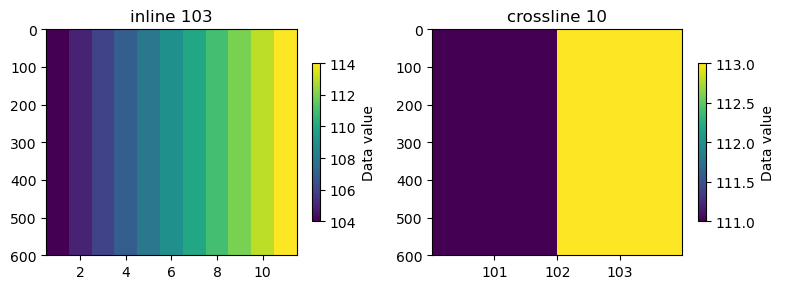

In [5]:
il103 = np.sort(dataset[dataset["iline"] == 103], order="xline")
xl10 = np.sort(dataset[dataset["xline"] == 10], order="iline")
nti, nsi = il103["data"].shape
ntx, nsx = xl10["data"].shape

fig1a, ax1a = plt.subplots(1, 2, figsize=(8,3))
im10 = ax1a[0].imshow(il103["data"].T, aspect="auto", extent=(il103["xline"][0]-0.49, il103["xline"][-1]+0.49, nsi-1, 0), interpolation="nearest")
ax1a[0].set_title("inline 103")
plt.colorbar(im10, ax=ax1a[0], orientation="vertical", shrink=0.7, label="Data value")
im11 = ax1a[1].imshow(xl10["data"].T, aspect="auto", extent=(xl10["iline"][0]-0.99, xl10["iline"][-1]+0.99, nsx-1, 0), interpolation="nearest")
ax1a[1].set_title("crossline 10")
plt.colorbar(im11, ax=ax1a[1], orientation="vertical", shrink=0.7, label="Data value")
plt.tight_layout()
plt.show()

In order to form a 3D cube, we can call the __ensemble2cube__ function. In this case, we would not even have to specify the trace header mnemonics to form the cube as these are the default mnemonics anyway:

In [6]:
cube = seisio.tools.ensemble2cube(dataset, idef="xline", jdef="iline")

INFO: Cube dimensions: (11, 4, 601)
INFO: I defined by: 'xline' (1 to 11, increment 1)
INFO: J defined by: 'iline' (101 to 107, increment 2)


In [7]:
nx, ni = cube.shape
log.info("Number of traces in cube: %d", ni*nx)

INFO: Number of traces in cube: 44


We now have 44 traces instead of 38. Let's plot the geometry again using the same crossplot approach as before:

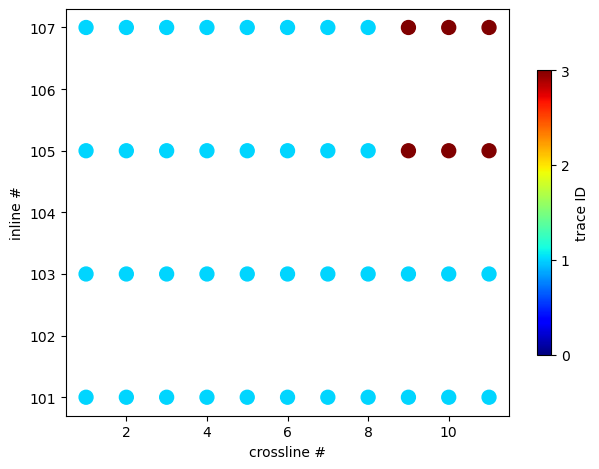

In [8]:
fig2, ax2 = plt.subplots(1, 1)
sc2 = ax2.scatter(cube["xline"], cube["iline"], c=cube["trid"], s=100, cmap="jet", vmin=0, vmax=3)
ax2.set_xlabel("crossline #")
ax2.set_ylabel("inline #")
plt.colorbar(sc2, ax=ax2, orientation="vertical", label="trace ID", format="%d", ticks=[0, 1, 2, 3], shrink=0.7)
plt.tight_layout()
plt.show()

It is obvious that six traces have been padded to form a regular cube. The trace ID is set to three for those traces, and the actual data values are np.nan, i.e., when plotting the data using matplotlib, the values will be ignored. Let's plot the same inline and crossline again as shown above. Inline 103 is the second entry on the inline-axis, crossline 10 is the ninth entry on the crossline-axis. This could also be determined automatically as the ranges and increments are known (see INFO logging output of the ensemble2cube function call above).

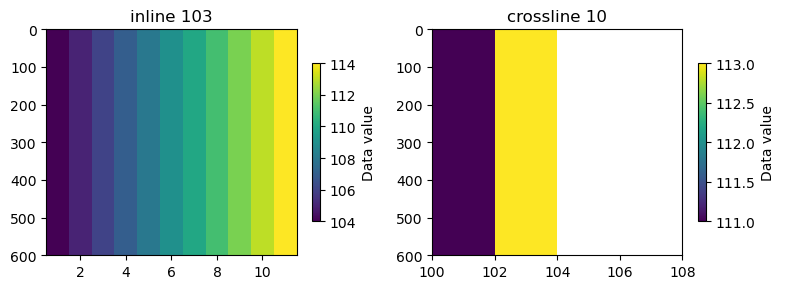

In [9]:
cil103 = cube[:, 1]
cxl10 = cube[9, :]
cnti, cnsi = cil103["data"].shape
cntx, cnsx = cxl10["data"].shape

fig2a, ax2a = plt.subplots(1, 2, figsize=(8,3))
im20 = ax2a[0].imshow(cil103["data"].T, aspect="auto", extent=(cil103["xline"][0]-0.5, cil103["xline"][-1]+0.5, cnsi-1, 0), interpolation="nearest")
ax2a[0].set_title("inline 103")
plt.colorbar(im20, ax=ax2a[0], orientation="vertical", shrink=0.7, label="Data value")
im21 = ax2a[1].imshow(cxl10["data"].T, aspect="auto", extent=(cxl10["iline"][0]-1, cxl10["iline"][-1]+1, cnsx-1, 0), interpolation="nearest")
ax2a[1].set_title("crossline 10")
plt.colorbar(im21, ax=ax2a[1], orientation="vertical", shrink=0.7, label="Data value")
plt.tight_layout()
plt.show()

As expected, this gives basically the same result as before but the padding for crossline 10 can clearly be seen. The cube could easily be displayed as chair plot using mayavi or other 3D plotting tools.